In [33]:
# importing required libraries
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [34]:
# Load data
df = pd.read_csv('Startup_Scoring_Dataset.csv')

# Check for missing values and datatypes
print(df.info())
print(df.isnull().sum())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 7 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   startup_id               100 non-null    object
 1   team_experience          100 non-null    int64 
 2   market_size_million_usd  100 non-null    int64 
 3   monthly_active_users     100 non-null    int64 
 4   monthly_burn_rate_inr    100 non-null    int64 
 5   funds_raised_inr         100 non-null    int64 
 6   valuation_inr            100 non-null    int64 
dtypes: int64(6), object(1)
memory usage: 5.6+ KB
None
startup_id                 0
team_experience            0
market_size_million_usd    0
monthly_active_users       0
monthly_burn_rate_inr      0
funds_raised_inr           0
valuation_inr              0
dtype: int64


DATA PREPROCESSING


In [35]:
# Simple imputation: fill missing numeric values with median (robust to outliers)
num_cols = df.select_dtypes(include='number').columns
df[num_cols] = df[num_cols].fillna(df[num_cols].median())    # to handle missing values(if any)

In [36]:
# Define columns: positive (higher is better), negative (lower is better)
positive_features = [
    'team_experience',
    'market_size_million_usd',
    'monthly_active_users',
    'funds_raised_inr',
    'valuation_inr'
]
negative_features = ['monthly_burn_rate_inr']

# Fit scaler only on relevant columns
scaler = MinMaxScaler()
df[positive_features] = scaler.fit_transform(df[positive_features])

# For negative features, invert after scaling so lower is better
df[negative_features] = 1 - scaler.fit_transform(df[negative_features])

# Rename columns for clarity
for col in positive_features + negative_features:
    df[col + '_norm'] = df[col]
    
# List of normalized columns
norm_cols = [col + '_norm' for col in positive_features + negative_features]

# Print min and max for each normalized feature
print("Normalized feature ranges:")
print(df[norm_cols].agg(['min', 'max']))

Normalized feature ranges:
     team_experience_norm  market_size_million_usd_norm  \
min                   0.0                           0.0   
max                   1.0                           1.0   

     monthly_active_users_norm  funds_raised_inr_norm  valuation_inr_norm  \
min                        0.0                    0.0                 0.0   
max                        1.0                    1.0                 1.0   

     monthly_burn_rate_inr_norm  
min                         0.0  
max                         1.0  


FEATURE WEIGHTING AND COMPOSITE SCORING

In [37]:

# List of original features (not the _norm columns)
features = [
    'team_experience',
    'market_size_million_usd',
    'monthly_active_users',
    'monthly_burn_rate_inr',
    'funds_raised_inr',
    'valuation_inr'
]

# Use normalized data for PCA
normalized_data = df[[f + '_norm' for f in features]].values

# PCA
pca = PCA(n_components=6)  # 6 features
pca.fit(normalized_data)

# Variance explained by each component
explained_variance = pca.explained_variance_ratio_

# Use as proxy for weights (normalized)
pca_weights = pd.Series(explained_variance, index=features)
pca_weights_normalized = pca_weights / pca_weights.sum()

# Display weights as percentages (rounded)
print(pca_weights_normalized.round(4))

team_experience            0.2242
market_size_million_usd    0.2128
monthly_active_users       0.1734
monthly_burn_rate_inr      0.1632
funds_raised_inr           0.1141
valuation_inr              0.1123
dtype: float64


In [38]:

# Map feature names to their normalized column names
norm_feature_cols = [f + '_norm' for f in pca_weights_normalized.index]

# Calculate the weighted sum for each startup (composite score out of 100)
df['startup_score_pca'] = (df[norm_feature_cols] * pca_weights_normalized.values).sum(axis=1) * 100

# Preview the new score column
print(df[['startup_id', 'startup_score_pca']].head())

  startup_id  startup_score_pca
0       S001          56.526435
1       S002          38.792383
2       S003          39.912413
3       S004          44.730748
4       S005          53.344057


RANKING AND INTERPRETATION

In [19]:
# Sort startups by PCA-based score (descending)
df_sorted = df.sort_values(['startup_score_pca'], ascending=False).reset_index(drop=True)

# Add rank column (1 = best)
df_sorted['rank'] = df_sorted.index + 1

# Display top 10 and bottom 10
top_10 = df_sorted.head(10)
bottom_10 = df_sorted.tail(10)

print("Top 10 Startups:")
print(top_10[['startup_id', 'startup_score_pca', 'rank']])

print("\nBottom 10 Startups:")
print(bottom_10[['startup_id', 'startup_score_pca', 'rank']])

Top 10 Startups:
  startup_id  startup_score_pca  rank
0       S006          81.765919     1
1       S077          76.739612     2
2       S013          74.643113     3
3       S045          73.876991     4
4       S097          73.695102     5
5       S033          72.989928     6
6       S043          70.409647     7
7       S012          70.241586     8
8       S082          70.196562     9
9       S029          69.821965    10

Bottom 10 Startups:
   startup_id  startup_score_pca  rank
90       S026          33.495459    91
91       S063          33.487224    92
92       S074          33.435190    93
93       S051          32.873177    94
94       S091          32.703562    95
95       S084          30.807495    96
96       S052          30.408100    97
97       S058          29.902489    98
98       S079          28.873099    99
99       S055          26.592816   100


VISUALIZATION

In [39]:

# Set style for better-looking plots
sns.set(style="whitegrid")
plt.rcParams["figure.figsize"] = (12, 6)

C:\Users\srahu\AppData\Local\Temp\ipykernel_17732\2333506971.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(


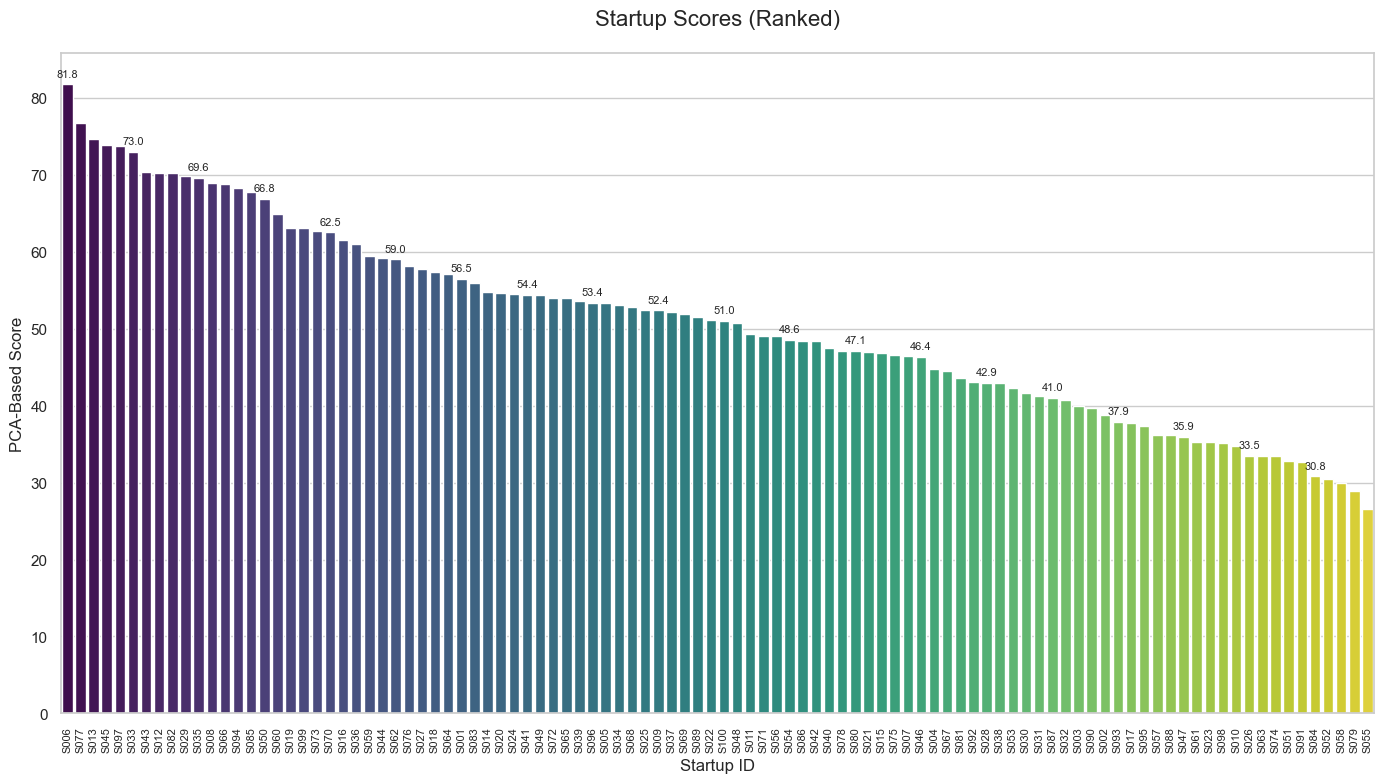

In [28]:
plt.figure(figsize=(14, 8))
ax = sns.barplot(
    x='startup_id', 
    y='startup_score_pca', 
    data=df_sorted, 
    palette='viridis'
)
plt.title('Startup Scores (Ranked)', fontsize=16, pad=20)
plt.xlabel('Startup ID', fontsize=12)
plt.ylabel('PCA-Based Score', fontsize=12)
plt.xticks(rotation=90, fontsize=8)
plt.tight_layout()

# Add score values on top of bars (every 5th bar for clarity)
for i, score in enumerate(df_sorted['startup_score_pca']):
    if i % 5 == 0:  # Label every 5th bar
        ax.text(i, score + 1, f'{score:.1f}', ha='center', fontsize=8)

plt.show()

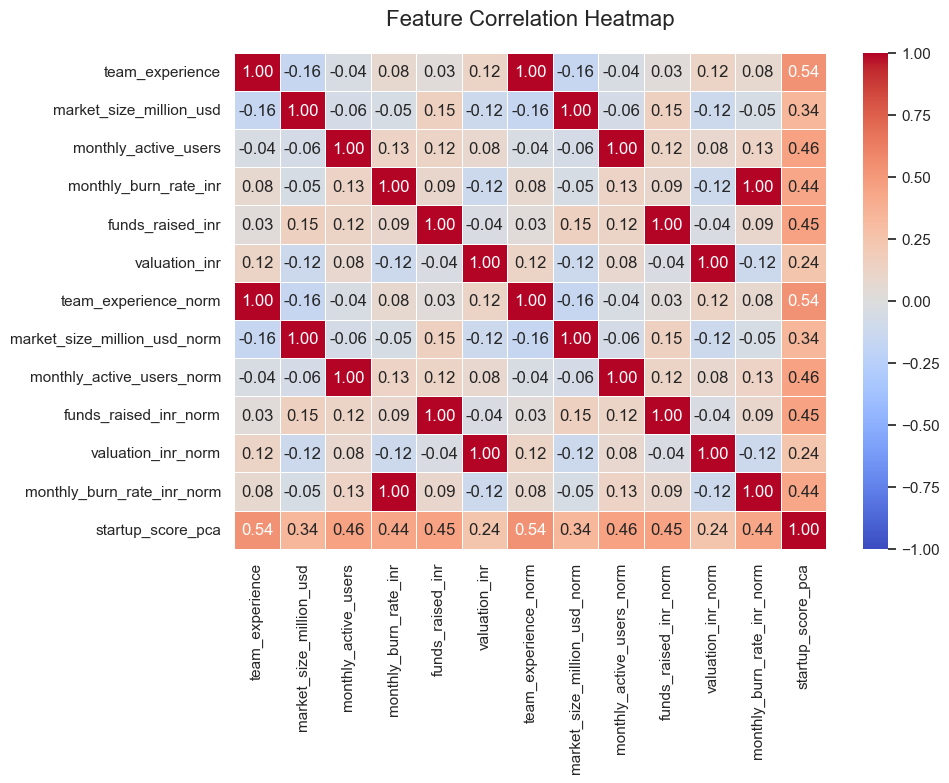

In [29]:
# Select only the original (non-normalized) numeric columns for correlation
numeric_cols = df.select_dtypes(include=['int64', 'float64']).columns
corr_matrix = df[numeric_cols].corr()

plt.figure(figsize=(10, 8))
sns.heatmap(
    corr_matrix, 
    annot=True, 
    cmap='coolwarm', 
    fmt='.2f', 
    linewidths=0.5,
    vmin=-1, 
    vmax=1
)
plt.title('Feature Correlation Heatmap', fontsize=16, pad=20)
plt.tight_layout()
plt.show()

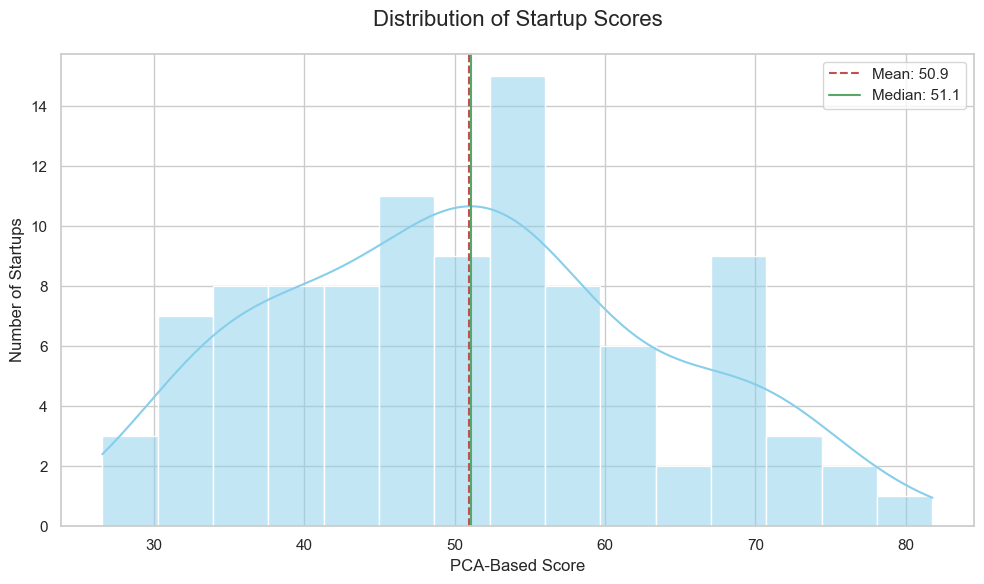

In [30]:
plt.figure(figsize=(10, 6))
sns.histplot(
    df_sorted['startup_score_pca'], 
    bins=15, 
    kde=True, 
    color='skyblue'
)
plt.title('Distribution of Startup Scores', fontsize=16, pad=20)
plt.xlabel('PCA-Based Score', fontsize=12)
plt.ylabel('Number of Startups', fontsize=12)

# Add vertical line for mean and median
mean_score = df_sorted['startup_score_pca'].mean()
median_score = df_sorted['startup_score_pca'].median()
plt.axvline(mean_score, color='r', linestyle='--', label=f'Mean: {mean_score:.1f}')
plt.axvline(median_score, color='g', linestyle='-', label=f'Median: {median_score:.1f}')

plt.legend()
plt.tight_layout()
plt.show()

Documentation

1.   Why I Chose These Weights:
I used Principal Component Analysis (PCA) to identify which features contribute most to the overall variation in the dataset. This allowed me to assign objective and data-driven weights to each feature, based on how important they are for differentiating startups.

The resulting weights showed:

Team Experience, Market Size, and Monthly Active Users were the most important factors, which makes sense in real startup evaluation.

Burn Rate, Funding, and Valuation had relatively lower importance, since they are often results of a good business, not the cause.

2.   How I Handled Negatively Correlated Metrics (Burn Rate):
A higher burn rate means a startup is spending more money every month — which is not always a good sign.

Since most other features are "the higher, the better", I inverted the burn rate using the formula:
inverted_burn = 1 - normalized_burn
This way, a lower burn gets a higher score, which keeps the scoring direction consistent across all features.

3.   Surprises or Insights from the Ranking:
Some startups with moderate funding and valuation still ranked high due to strong team experience and large market size.

A few startups with high burn rates and low user base scored very low, even if they had raised a lot of money — showing that just raising funds doesn't make a startup healthy.

The most successful startups had a balance of good team, big market, growing user base, and controlled expenses — which aligns with real-world investment logic.